# Carga de datos

In [2]:
!pip install unidecode
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /home/sergon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sergon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sergon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Librerías para manejo de datos
import pandas as pd
pd.set_option('display.max_columns', 25) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Numero máximo de filas a mostar
import numpy as np
np.random.seed(3301)
import pandas as pd
# Para preparar los datos
from sklearn.preprocessing import LabelEncoder
# Para crear el arbol de decisión
from sklearn.tree import DecisionTreeClassifier
# Para usar KNN como clasificador
from sklearn.neighbors import KNeighborsClassifier
# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split
# Para evaluar el modelo
#from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
#from sklearn.metrics import plot_confusion_matrix
# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold
#Librerías para la visualización
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from wordcloud import WordCloud
import unidecode
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import spacy

In [4]:
ubi = './data/ODScat_345.xlsx'

In [5]:
df_ods = pd.read_excel(ubi)

# Entendimiento de los datos

## 1.1 Perfilamiento de datos

In [8]:
df_ods.shape

(4049, 2)

Se evidencion que hay 4049 opiniones sobre problematicas relacionadas con los ODS

In [10]:
df_ods.sample(5)

Textos_espanol  sdg
3202  Por lo tanto, necesitan desarrollar fuertes ví...    4
2667  Prensa feminista, 2007), pág. 212. Comenzó a e...    5
1374  El maestro de preescolar, el maestro de primer...    4
1106  Aquellos que hablan un idioma europeo tienen p...    4
4022  Además, el plan no solo cubre al ejército cana...    5

La informacion cuenta con dos columnas, la primera Textos_espanol contiene el texto con la opinion del ciudadano, la segunda es el numero de ODS que le corresponde (columna que debemos predecir)

In [12]:
df_ods['sdg'].value_counts()

sdg
5    1451
4    1354
3    1244
Name: count, dtype: int64

El DataFrame df_ods['sdg'] contiene la clasificación de las opiniones ciudadanas asociadas a los Objetivos de Desarrollo Sostenible (ODS) 3, 4, y 5. La distribución es la siguiente:
ODS 5 (Igualdad de género): 1451 opiniones.
ODS 4 (Educación de calidad): 1354 opiniones.
ODS 3 (Salud y bienestar): 1244 opiniones.
Esto sugiere que la mayor parte de las opiniones están relacionadas con el ODS 5.

In [14]:
longitudes = df_ods['Textos_espanol'].apply(len)
df_ods['text_length'] = longitudes
longitudes.to_frame()

Textos_espanol
0                944
1                476
2               1207
3               1090
4                895
...              ...
4044             822
4045             514
4046             445
4047            1017
4048             728

[4049 rows x 1 columns]

In [15]:
longitudes.describe().to_frame()

Textos_espanol
count     4049.000000
mean       699.632502
std        228.988965
min        294.000000
25%        531.000000
50%        657.000000
75%        827.000000
max       1513.000000

El campo Textos_espanol contiene las opiniones en español, y se ha calculado la longitud de cada texto.
Las características de las longitudes son:
Número de textos: 4049 opiniones.
Longitud promedio de los textos: 699.63 caracteres.
Desviación estándar: 228.99 caracteres.
Mínimo: 294 caracteres.
Mediana (50%): 657 caracteres.
Máximo: 1513 caracteres.
La mayoría de los textos están en un rango relativamente compacto entre 531 y 827 caracteres.

In [17]:
# Palabras mas comunes
spanish_stop_words = stopwords.words('spanish')

vectorizer = CountVectorizer(stop_words=spanish_stop_words)
word_count_matrix = vectorizer.fit_transform(df_ods['Textos_espanol'])
word_counts = np.asarray(word_count_matrix.sum(axis=0)).flatten()
word_frequencies = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'count': word_counts})
word_frequencies.sort_values(by='count', ascending=False).head(20)

word  count
13192      mujeres   3028
17494        salud   1639
9722        género   1523
7089     educación   1460
14503       países   1410
2297      atención   1270
13864         ocde    992
8141   estudiantes    977
17832    servicios    891
16000       pueden    845
9997       hombres    842
2605          años    799
7850      escuelas    749
5960    desarrollo    733
13566        nivel    731
19196      trabajo    714
18062      sistema    711
3186       calidad    689
7181       ejemplo    676
15999        puede    665

El análisis de frecuencia de palabras muestra que los términos más comunes en las opiniones ciudadanas están estrechamente relacionados con los Objetivos de Desarrollo Sostenible (ODS) que estamos analizando.
"Mujeres" es la palabra más mencionada con 3028 apariciones, lo que refleja la relevancia del ODS 5 (Igualdad de Género) en las opiniones. Esto sugiere que los ciudadanos priorizan las discusiones sobre la igualdad de género y los derechos de las mujeres.
Otros términos como "salud" (1639 menciones), "género" (1523 menciones), "educación" (1460 menciones), y "países" (1410 menciones) también son prominentes. Esto sugiere que el ODS 3 (Salud y Bienestar) y el ODS 4 (Educación de Calidad) son igualmente importantes en las opiniones ciudadanas.

In [19]:
# Bigramas mas comunes
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=spanish_stop_words)
bigram_count_matrix = bigram_vectorizer.fit_transform(df_ods['Textos_espanol'])
bigram_counts = np.asarray(bigram_count_matrix.sum(axis=0)).flatten()
bigram_frequencies = pd.DataFrame({'bigram': bigram_vectorizer.get_feature_names_out(), 'count': bigram_counts})
bigram_frequencies.sort_values(by='count', ascending=False).head(20)


bigram  count
82663        igualdad género    332
17624      atención primaria    307
145847          salud mental    298
119839           países ocde    268
102415       mercado laboral    204
81083        hombres mujeres    188
106165       mujeres hombres    186
149867               si bien    164
17571        atención médica    161
54188     educación superior    157
77971                gã nero    126
17655         atención salud    124
149311       servicios salud    124
45012       derechos humanos    118
159288       toma decisiones    116
93762            largo plazo    114
73898         fuerza laboral    109
147303   secundaria superior    108
131613         promedio ocde    106
54161   educación secundaria    104

El bigrama más común es "igualdad género", con 332 menciones. Esto refuerza la importancia del ODS 5, indicando que muchas opiniones se enfocan en la igualdad de género como un tema prioritario.
Otros bigramas importantes incluyen "atención primaria" (307 menciones) y "salud mental" (298 menciones), los cuales están relacionados con el ODS 3, sugiriendo que los temas de acceso a servicios médicos esenciales y la salud mental son recurrentes en las preocupaciones ciudadanas.
"Educación superior" (157 menciones) también aparece como un bigrama relevante, lo que vincula estas opiniones con el ODS 4, destacando la importancia del acceso y la calidad en la educación superior.

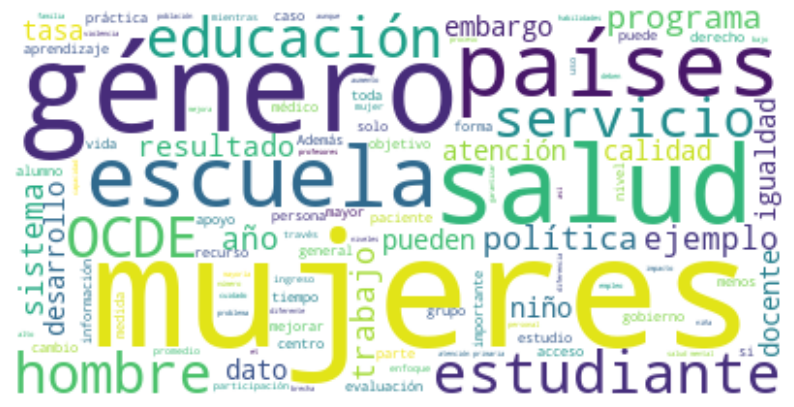

In [21]:
# Nube de palabras
wordcloud = WordCloud(stopwords=spanish_stop_words, background_color="white", max_words=100).generate(" ".join(df_ods['Textos_espanol']))

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

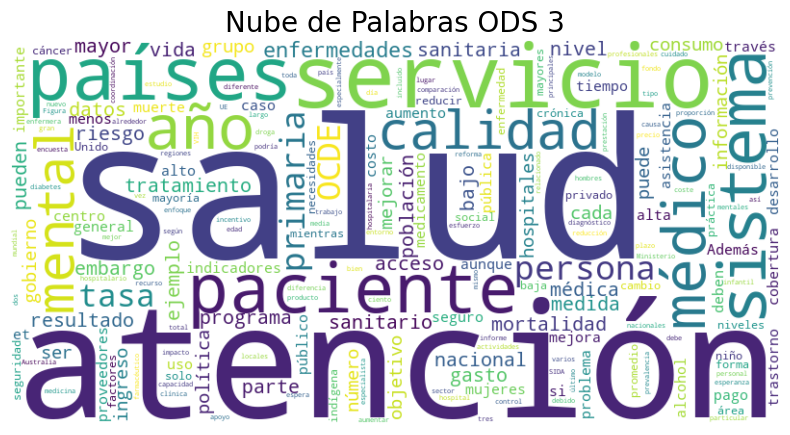

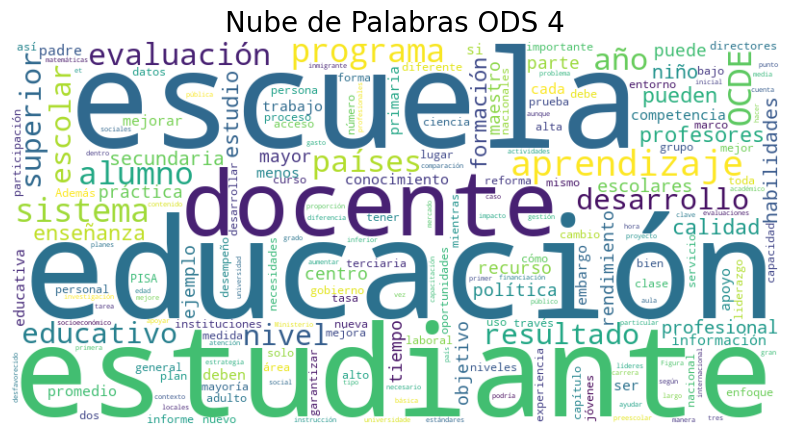

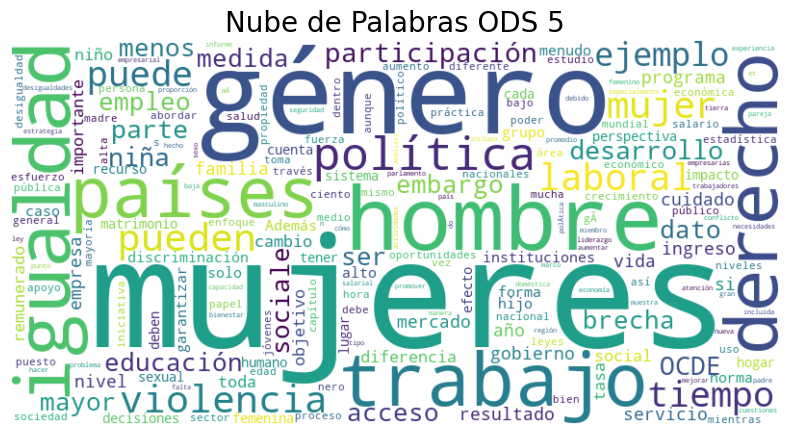

In [22]:
# Palabras mas comunes por ODS 
textos_ods3 = " ".join(df_ods[df_ods['sdg'] == 3]['Textos_espanol'])
textos_ods4 = " ".join(df_ods[df_ods['sdg'] == 4]['Textos_espanol'])
textos_ods5 = " ".join(df_ods[df_ods['sdg'] == 5]['Textos_espanol'])

#  generar la nube de palabras
def generar_nube(texto, titulo):
    wordcloud = WordCloud(stopwords=spanish_stop_words, width=800, height=400, background_color='white', collocations=False).generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=20)
    plt.show()

# Generar nubes de palabras para cada ODS
generar_nube(textos_ods3, 'Nube de Palabras ODS 3')
generar_nube(textos_ods4, 'Nube de Palabras ODS 4')
generar_nube(textos_ods5, 'Nube de Palabras ODS 5')

Se puede visualizar en esta nube de palabras, que las palabras entre su tamaño sea mayor, es debido a que se repite mas veces dentro de los datos, asi teniendo entre los datos mas repetido con palabras mas grandes genero, salud, mujeres, paises, escuela etc...

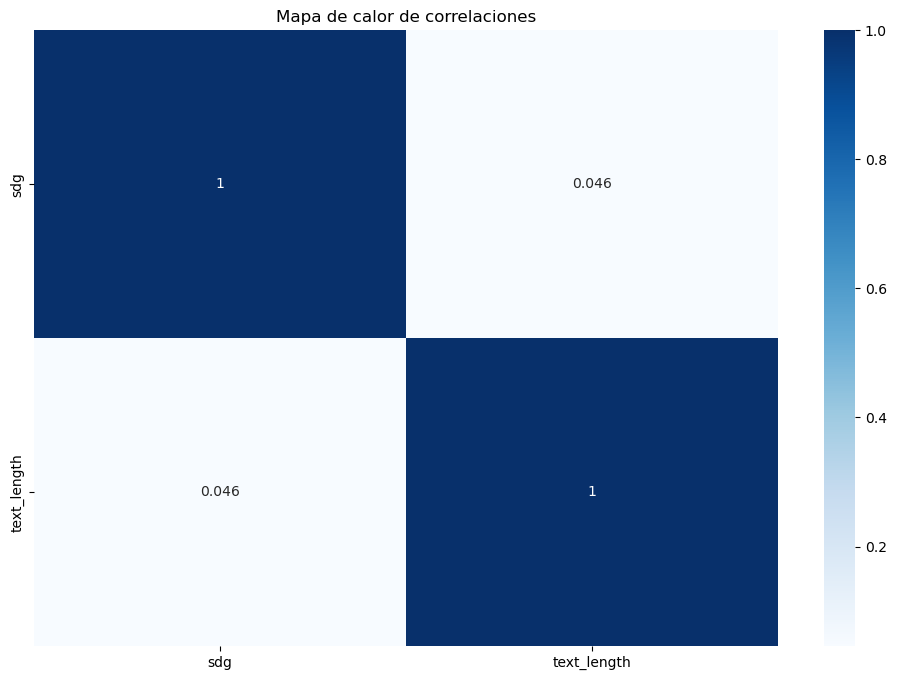

In [24]:
# Correlación entre la longitud de los textos y las clases
class_length_corr = df_ods[['sdg', 'text_length']].corr()


# correlación entre variables numéricas para buscar dependencias
datos_numericos = df_ods.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(datos_numericos.corr(),  cmap="Blues", annot=True)
plt.title('Mapa de calor de correlaciones')
plt.show()

El valor de correlación es 0.046, lo cual indica una correlación positiva muy débil entre el ODS asociado a cada opinión (sdg) y la longitud del texto (text_length).
Este valor tan bajo sugiere que la longitud del texto no está significativamente relacionada con el ODS al que corresponde la opinión ciudadana. En otras palabras, no parece haber una relación fuerte o evidente entre la cantidad de palabras usadas y si una opinión está más relacionada con el ODS 3, 4 o 5. La correlación de una variable consigo misma es siempre 1, como se observa en los valores de la diagonal principal del mapa de calor.

## 1.2 Calidad de datos

### 1.2.1 Completitud

In [28]:
# Porcentaje de valores nulos por columna
((df_ods.isnull().sum()/df_ods.shape[0])).sort_values(ascending=False)

Textos_espanol    0.0
sdg               0.0
text_length       0.0
dtype: float64

No se encuentra valores nulos en ninguna columna, ni por el contenido,ni el texto, ni el largo del texto

### 1.2.2 Unicidad

In [31]:
df_ods.duplicated(keep = False).sum()

0

Los datos son unicos y no se repiten.

### 1.2.3 Consistencia

In [34]:
df_ods.dtypes

Textos_espanol    object
sdg                int64
text_length        int64
dtype: object


Las columnas y sus datos son consistentes con lo que se espera segun el modelo de datos, al ser textos tendran que ser manipulados mas adelante con normalizacion y tokenizacion

### 1.2.4 Validez

In [37]:
df_ods["sdg"].value_counts(dropna=False)

sdg
5    1451
4    1354
3    1244
Name: count, dtype: int64

# Preparacion de datos

Resolver problemas de codificacion

In [41]:
# mapa de uft a ansi
utf8_to_ansi_map = {
    'Ã¡': 'á', 'Ã©': 'é', 'Ã­': 'í', 'Ã³': 'ó', 'Ãº': 'ú',
    'Ã±': 'ñ', 'ÃÁ': 'Á', 'Ã‰': 'É', 'ÃÍ': 'Í', 'ÃÓ': 'Ó',
    'ÃÚ': 'Ú', 'Ã‘': 'Ñ', 'Â¿': '¿', 'Â¡': '¡'
}

# funcion para remplazar las malas codificaciones
def replace_utf8_with_ansi(text):
    for utf8_char, ansi_char in utf8_to_ansi_map.items():
        text = text.replace(utf8_char, ansi_char)
    return text

df_manipulado = df_ods.copy()
# aplicar codificacion
df_manipulado['Textos_espanol'] = df_ods['Textos_espanol'].apply(replace_utf8_with_ansi)
df_manipulado.sample(5)


Textos_espanol  sdg  text_length
530   Las habilidades sociales son un determinante c...    3          599
847   En el Reino Unido, los ADE pueden representar ...    3          594
15    Estas estaciones cuentan con asistentes médico...    3          547
4037  A pesar de que las mujeres están en el mercado...    5          773
1229  Se consideró que el éxito de las reformas al p...    4          474

Verificamos y todos los textos se encuentran en español por lo tanto es importante tener una buena preparcion de datos con respecto a los caracteres especiales.  Se define un mapeo entre los caracteres UTF-8 mal interpretados y sus equivalentes en ANSI para hacer este proceso. Se extrae una muestra de 5 filas aleatorias del DataFrame df_manipulado para verificar cómo quedaron los textos después de la corrección

Convertir en tokens

In [44]:
def preprocess_text(text):
    # poner en minusculas
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # remover puntuacion y stopwords
    tokens = [word for word in tokens if word.isalnum() and word not in spanish_stop_words]
    return ' '.join(tokens)


df_manipulado['processed_text'] = df_manipulado['Textos_espanol'].apply(preprocess_text)
df_manipulado.sample(5)

Textos_espanol  sdg  text_length  \
1733  De hecho, se ha comprobado que la educación en...    4          624   
9     En este sentido, es una forma eficaz de mejora...    3          862   
3464  Las mujeres y las niñas deben tener el mismo a...    5          898   
3239  La OCDE está elaborando mejores datos sobre lo...    3          881   
1586  Esto podría implicar directrices para las escu...    4          383   

                                         processed_text  
1733  hecho comprobado educación primera infancia fa...  
9     forma eficaz mejorar eficacia calidad servicio...  
3464  mujeres niñas deben tener mismo acceso servici...  
3239  ocde elaborando mejores datos resultados asist...  
1586  podría implicar directrices escuelas celebraci...

El objetivo es normalizar los textos para futuros análisis, eliminando caracteres irrelevantes y facilitando el procesamiento natural del lenguaje (NLP).

**Convertir a minúsculas (text.lower()):**

Esta conversión uniformiza las palabras, eliminando la diferencia entre mayúsculas y minúsculas. Por ejemplo, "Gobierno" y "gobierno" serán tratadas como la misma palabra.


**Tokenización (word_tokenize(text)):**

La tokenización separa el texto en palabras o "tokens". Esto para poder evaluar las palabras invidualmente
Ejemplo: "El consumo anual de alcohol" → ["El", "consumo", "anual", "de", "alcohol"].

**Eliminar puntuación y palabras vacías:**

Puntuación: Se eliminan tokens que no son alfanuméricos, como comas y puntos.
Stopwords: Las palabras vacías (palabras comunes como "de", "el", "y") se eliminan. Esto es útil porque estas palabras no suelen agregar significado a los análisis de texto.


**Unir los tokens (' '.join(tokens)):**

Se reconstruye el texto a partir de los tokens filtrados. El resultado es un texto sin puntuación, palabras comunes, y con solo palabras relevantes para el análisis.

Lemalizacion

In [47]:
#  transformar a vectores usando TF-IDF

vectorizerRF = TfidfVectorizer()
X = vectorizerRF.fit_transform(df_manipulado['processed_text'])
y = df_ods['sdg']

Convertimos cada texto en un vector numérico, donde cada entrada representa la relevancia de una palabra para ese texto en particular. Este vector será usado como entrada para el modelo de clasificación.

# Construccion del modelo

## Random forest

In [51]:
# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Hacemos predicciones
y_pred = rf_model.predict(X_test)

# Evaluamos el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['ODS 3', 'ODS 4', 'ODS 5'])
print(accuracy)
print(report)

0.9703703703703703
              precision    recall  f1-score   support

       ODS 3       0.98      0.98      0.98       250
       ODS 4       0.96      0.97      0.97       268
       ODS 5       0.98      0.96      0.97       292

    accuracy                           0.97       810
   macro avg       0.97      0.97      0.97       810
weighted avg       0.97      0.97      0.97       810



Se utiliza un Random Forest con 100 árboles (n_estimators=100), que es un modelo de clasificación basado en la agregación de múltiples árboles de decisión. Es robusto y reduce el riesgo de sobreajuste.

**ODS 3:**

Precisión : 0.98, lo que significa que el 98% de las predicciones de la clase ODS 3 fueron correctas. El modelo rara vez clasifica erróneamente otros textos como ODS 3.

Recall: 0.98, lo que indica que el modelo pudo capturar el 98% de los textos que realmente pertenecen a ODS 3.

F1-Score: 0.98, que es un equilibrio excelente entre precisión y recall para esta clase. Esto refleja un rendimiento casi perfecto en ODS 3.

**ODS 4:**

Precisión : 0.96, lo que muestra que el modelo tiene una tasa de aciertos alta cuando predice ODS 4.

Recall: 0.97, lo que indica que el modelo fue capaz de identificar correctamente la mayoría de los textos que realmente pertenecen a ODS 4.

F1-Score: 0.97, lo que refleja una ligera mejora en comparación con la precisión, lo que significa que hay un excelente equilibrio entre las métricas en esta clase.

**ODS 5:**

Precisión : 0.98, lo que indica que la tasa de aciertos del modelo para las predicciones de ODS 5 es muy alta

Recall: 0.96, lo que significa que el 96% de los textos que pertenecen a ODS 5 fueron correctamente clasificados

F1-Score: 0.97, lo que muestra una fuerte consistencia entre precisión y recall, lo que indica un buen rendimiento global para esta clase

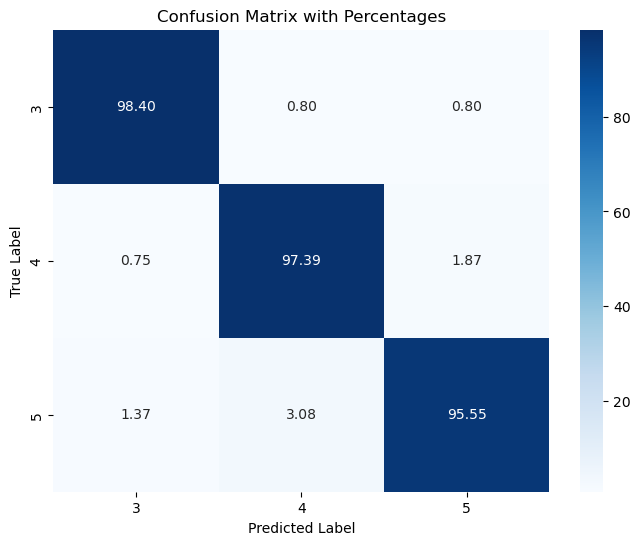

In [53]:
# generamos la matriz de confusion
cm = confusion_matrix(y_test, y_pred)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[3, 4, 5], yticklabels=[3, 4, 5])
plt.title('Confusion Matrix with Percentages')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**ODS 3 (fila 1):**

98.40% de los textos clasificados como ODS 3 son correctos.
0.80% de los textos que deberían ser ODS 3 se clasificaron incorrectamente como ODS 4.
0.80% de los textos que deberían ser ODS 3 se clasificaron incorrectamente como ODS 5.

Conclusión: El modelo tiene un rendimiento excelente en la clasificación de textos de ODS 3, con muy pocos errores de clasificación hacia las otras dos clases.


**ODS 4 (fila 2):**

97.39% de los textos clasificados como ODS 4 son correctos.
0.75% de los textos que deberían ser ODS 4 se clasificaron incorrectamente como ODS 3.
1.87% de los textos que deberían ser ODS 4 se clasificaron incorrectamente como ODS 5.

Conclusión: El modelo también muestra una gran precisión en ODS 4, con una leve confusión hacia ODS 5, pero la mayoría de las predicciones son correctas.


**ODS 5 (fila 3):**

95.55% de los textos clasificados como ODS 5 son correctos.
1.37% de los textos que deberían ser ODS 5 se clasificaron incorrectamente como ODS 3.
3.08% de los textos que deberían ser ODS 5 se clasificaron incorrectamente como ODS 4.

Conclusión: Aunque la precisión es alta, ODS 5 tiene la mayor confusión en comparación con las otras clases. Aproximadamente el 4.45% de los textos son clasificados erróneamente, principalmente hacia ODS 4.

## K Neighbors

In [56]:


vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_manipulado['processed_text'])
y = df_ods['sdg']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
knn = KNeighborsClassifier(n_neighbors=3)  # Default to 3 neighbors for now
knn.fit(X_train, y_train)

# predecir
y_pred = knn.predict(X_test)

# evaluar el modelo
classification_report_result = classification_report(y_test, y_pred)

# evaluamos el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['ODS 3', 'ODS 4', 'ODS 5'])
print(accuracy)
print(report)


0.9395061728395062
              precision    recall  f1-score   support

       ODS 3       0.93      0.93      0.93       250
       ODS 4       0.94      0.95      0.95       268
       ODS 5       0.94      0.93      0.94       292

    accuracy                           0.94       810
   macro avg       0.94      0.94      0.94       810
weighted avg       0.94      0.94      0.94       810



El algoritmo K-Nearest Neighbors (KNN) con 3 vecinos ha generado un resultado de clasificación con una precisión general de 0.94 (93.95%)

**ODS 3:**

Precisión : 0.93 significa que el 93% de las veces que el modelo predijo la clase ODS 3, estaba en lo correcto.

Recall: 0.93 indica que el modelo fue capaz de capturar el 93% de los textos que realmente pertenecen a ODS 3.

F1-Score: 0.93, que es un balance entre la precisión y el recall, muestra un buen rendimiento en esta clase.

**ODS 4:**

Precisión : 0.94 muestra que el modelo tiene una alta tasa de aciertos cuando predice ODS 4.

Recall: 0.95 indica que la mayoría de los textos pertenecientes a ODS 4 fueron correctamente clasificados.

F1-Score: 0.95, lo que muestra un equilibrio excelente entre la precisión y el recall para esta clase.

**ODS 5:**

Precisión : 0.94, lo que indica que la tasa de aciertos del modelo en predicciones de ODS 5 es alta.

Recall: 0.93 muestra que el 93% de los textos que pertenecen a ODS 5 fueron correctamente clasificados.

F1-Score: 0.94, mostrando una consistencia sólida entre precisión y recall en esta clase.

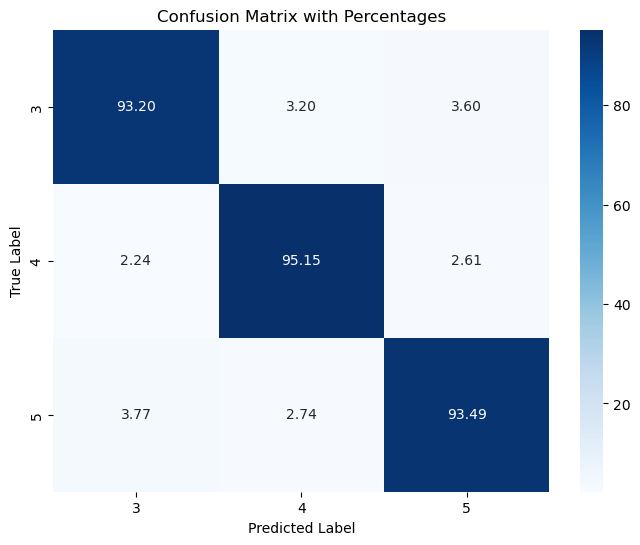

In [60]:
# generamos la matriz de confusion
cm = confusion_matrix(y_test, y_pred)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[3, 4, 5], yticklabels=[3, 4, 5])
plt.title('Confusion Matrix with Percentages')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**ODS 3 (fila 1):**

93.20% de los textos clasificados como ODS 3 son correctos. 3.20% de los textos que deberían ser ODS 3 se clasificaron incorrectamente como ODS 4. 3.60% de los textos que deberían ser ODS 3 se clasificaron incorrectamente como ODS 5.

Conclusión: El modelo tiene un buen rendimiento en la clasificación de textos de ODS 3, pero presenta errores de clasificación hacia las otras dos clases, particularmente con ODS 5.

**ODS 4 (fila 2):**

95.15% de los textos clasificados como ODS 4 son correctos. 2.24% de los textos que deberían ser ODS 4 se clasificaron incorrectamente como ODS 3. 2.61% de los textos que deberían ser ODS 4 se clasificaron incorrectamente como ODS 5.

Conclusión: El modelo muestra un gran rendimiento en ODS 4, con leves confusiones hacia ODS 3 y ODS 5, pero la mayoría de las predicciones son correctas.

**ODS 5 (fila 3):**

93.49% de los textos clasificados como ODS 5 son correctos. 3.77% de los textos que deberían ser ODS 5 se clasificaron incorrectamente como ODS 3. 2.74% de los textos que deberían ser ODS 5 se clasificaron incorrectamente como ODS 4.

Conclusión: Aunque la precisión es alta, ODS 5 presenta confusiones en comparación con las otras clases, especialmente con ODS 3. Aproximadamente el 6.51% de los textos son clasificados erróneamente.

## CART

In [63]:

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_manipulado['processed_text'])
y = df_ods['sdg']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
cart_model = DecisionTreeClassifier(random_state=42)
cart_model.fit(X_train, y_train)

y_pred = cart_model.predict(X_test)
# Evaluamos el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['ODS 3', 'ODS 4', 'ODS 5'])
print(accuracy)
print(report)

0.9246913580246914
              precision    recall  f1-score   support

       ODS 3       0.89      0.91      0.90       250
       ODS 4       0.94      0.91      0.92       268
       ODS 5       0.94      0.95      0.95       292

    accuracy                           0.92       810
   macro avg       0.92      0.92      0.92       810
weighted avg       0.92      0.92      0.92       810



El modelo de Árbol de Decisión (Decision Tree Classifier) ha generado un resultado de clasificación con una precisión general de 0.92 (92.47%)

**ODS 3:**

Precisión: 0.89 significa que el 89% de las veces que el modelo predijo la clase ODS 3, estuvo en lo correcto.
Recall: 0.91 indica que el modelo fue capaz de capturar el 91% de los textos que realmente pertenecen a ODS 3.
F1-Score: 0.90, que es un balance entre la precisión y el recall, muestra un rendimiento adecuado para esta clase.

**ODS 4:**

Precisión: 0.94 muestra que el modelo tiene una alta tasa de aciertos cuando predice ODS 4.
Recall: 0.91 indica que la mayoría de los textos pertenecientes a ODS 4 fueron correctamente clasificados, aunque hay algunas confusiones.
F1-Score: 0.92, lo que muestra un buen equilibrio entre la precisión y el recall para esta clase.

**ODS 5:**

Precisión: 0.94, lo que indica que la tasa de aciertos del modelo en predicciones de ODS 5 es alta.
Recall: 0.95 muestra que el 95% de los textos que pertenecen a ODS 5 fueron correctamente clasificados.
F1-Score: 0.95, demostrando una excelente consistencia entre precisión y recall en esta clase.

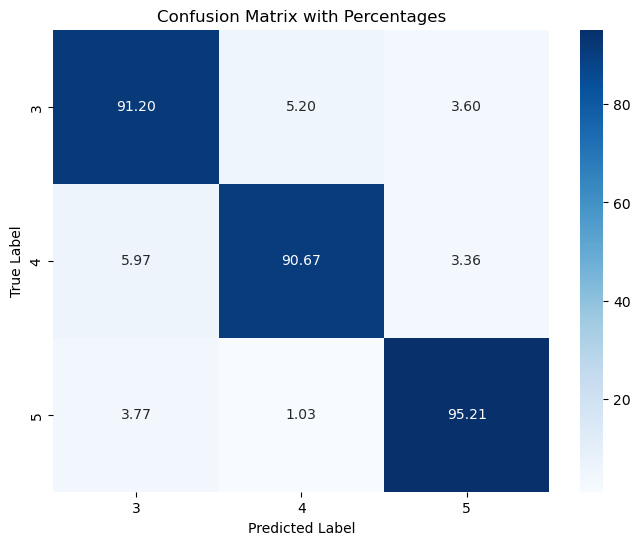

In [67]:
# generamos la matriz de confusion
cm = confusion_matrix(y_test, y_pred)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[3, 4, 5], yticklabels=[3, 4, 5])
plt.title('Confusion Matrix with Percentages')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Procesamiento de datos TEST

In [69]:
ubi_test = './data/TestODScat_345.xlsx'
df_test = pd.read_excel(ubi_test)

Resolver problemas de codificacion

In [71]:
df_test_manipulado = df_test.copy()
df_test_manipulado['Textos_espanol'] = df_test['Textos_espanol'].apply(replace_utf8_with_ansi)
df_test_manipulado.sample(5)

Textos_espanol  sdg
443  Estos períodos coinciden con distintas fases e...  NaN
653  Los hombres tienen tres veces más probabilidad...  NaN
259  Garantizar la igualdad de oportunidades para t...  NaN
337  Además, el objetivo de la Ley es contrarrestar...  NaN
546  Hacer que los beneficios del registro sean más...  NaN

Tokenizado

In [73]:
df_test_manipulado['processed_text'] = df_test_manipulado['Textos_espanol'].apply(preprocess_text)

Crear vector

In [75]:
X = vectorizerRF.transform(df_test_manipulado['processed_text'])

In [76]:
y_pred = rf_model.predict(X)
df_test["sdg"] = y_pred
df_test.sample(20)

Textos_espanol  sdg
604  Los 290 municipios financian la atención a la ...    3
490  Este estudio es un excelente ejemplo de una me...    5
158  Su nivel educativo sería inferior a 3 años en ...    4
632  Aún así, persiste una limitación en la producc...    5
287  Con este fin, los países de la OCDE utilizan c...    5
192  La estrategia podría incorporar elementos impo...    5
197  Por lo tanto, aunque las causas estructurales ...    5
653  Los hombres tienen tres veces más probabilidad...    5
96   En la mayoría de los países, las políticas mon...    5
627  Sin embargo, se debe tener el mismo cuidado pa...    5
432  De hecho, la mayoría de las personas necesitan...    5
109  El índice está construido para ser comparable ...    4
341  Es más probable que la invocación de los derec...    5
387  Los alumnos noruegos de quinto grado, que fue ...    4
444  La prevalencia del tabaquismo es más del doble...    3
470  Mientras estas mujeres solicitaban y recibían ...    5
200  Entre otras cosas, considera cómo se distribuy...    4
388  Dentro del contexto más amplio de ese proyecto...    3
694  La naturaleza da descanso y un poco de comida....    5
476  Es importante documentar y utilizar estudios d...    5

In [77]:
# guardar la informacion 
df_test.to_csv('./data/salida_test.csv', index=False)

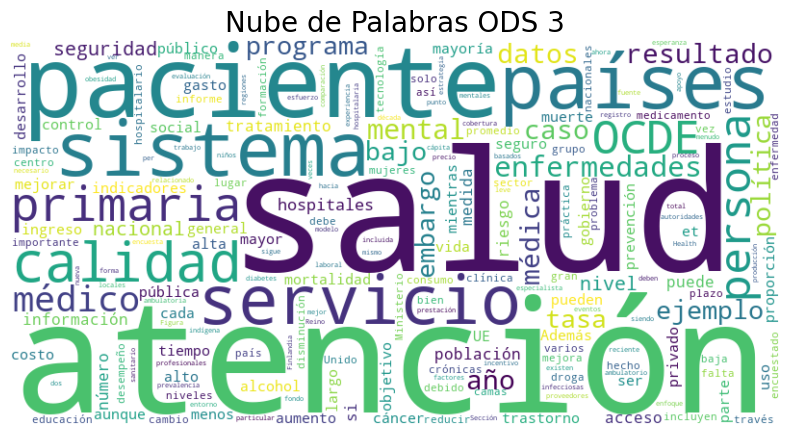

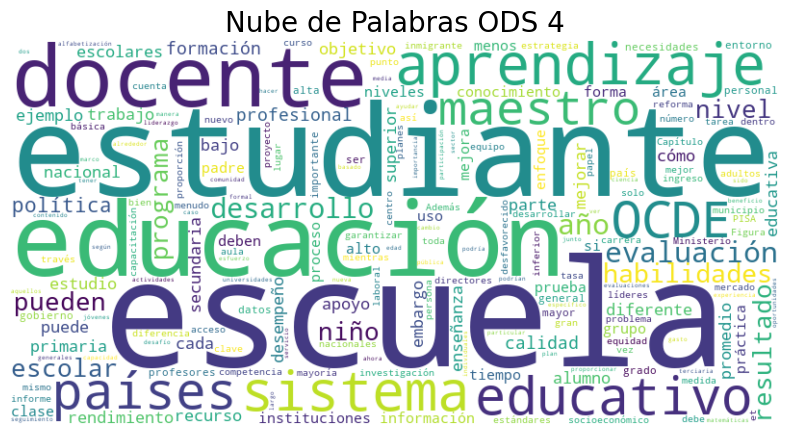

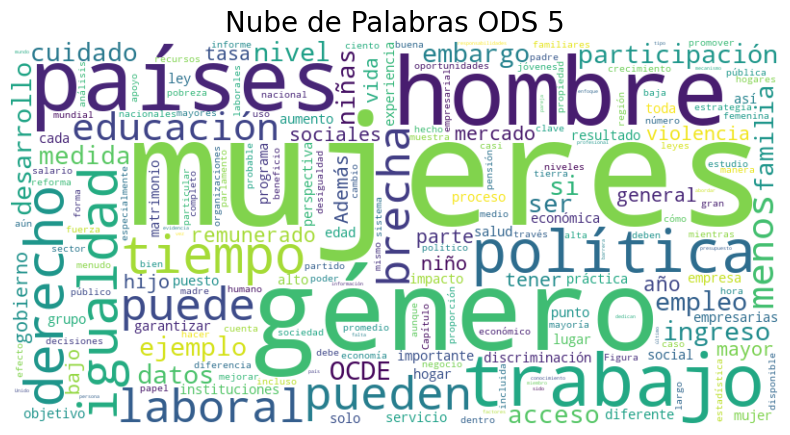

In [78]:
textos_ods3 = " ".join(df_test[df_test['sdg'] == 3]['Textos_espanol'])
textos_ods4 = " ".join(df_test[df_test['sdg'] == 4]['Textos_espanol'])
textos_ods5 = " ".join(df_test[df_test['sdg'] == 5]['Textos_espanol'])


# Función para generar la nube de palabras
def generar_nube(texto, titulo):
    wordcloud = WordCloud(stopwords=spanish_stop_words, width=800, height=400, background_color='white', collocations=False).generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=20)
    plt.show()

# Generar nubes de palabras para cada ODS


generar_nube(textos_ods3, 'Nube de Palabras ODS 3')
generar_nube(textos_ods4, 'Nube de Palabras ODS 4')
generar_nube(textos_ods5, 'Nube de Palabras ODS 5')

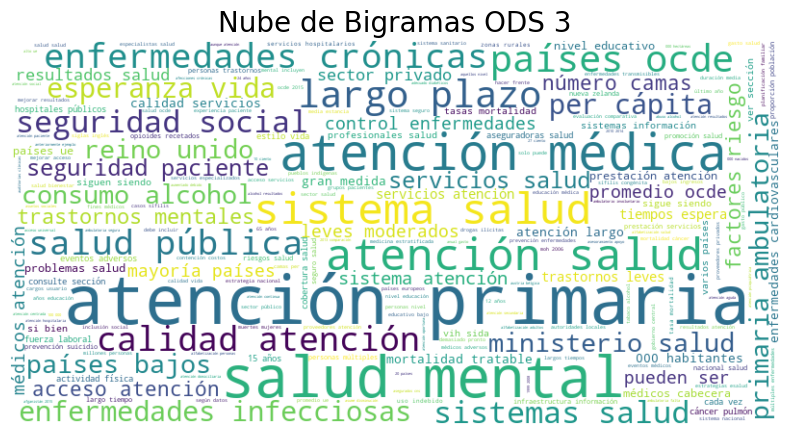

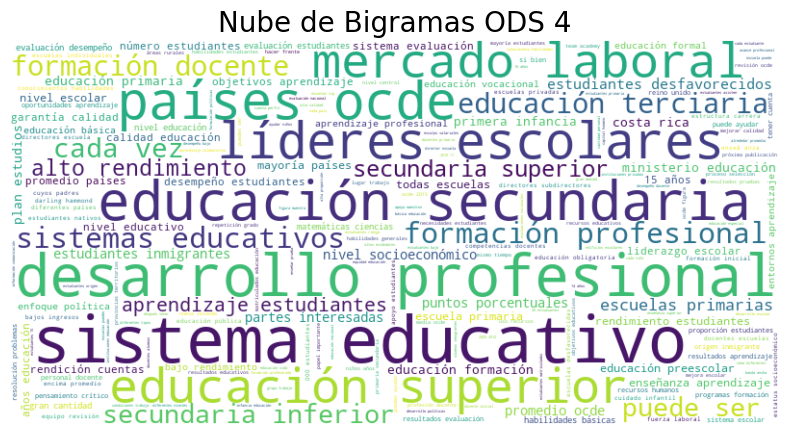

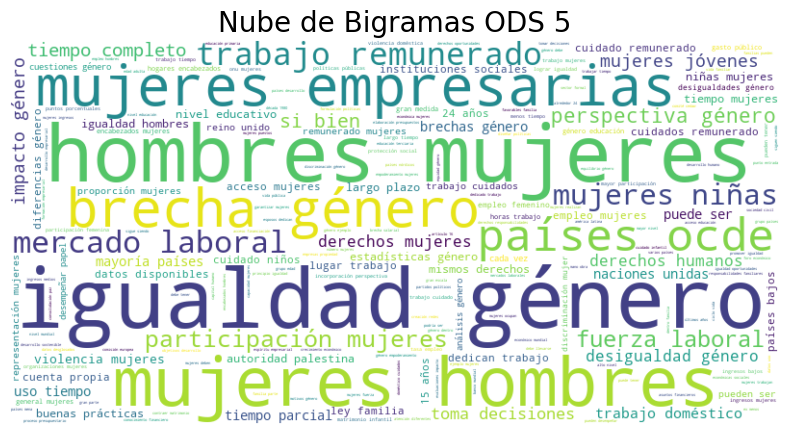

In [79]:
def generar_nube_bigramas(texto, titulo):
    # Extraer bigramas
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=spanish_stop_words)
    bigramas = vectorizer.fit_transform([texto])
    bigrama_frecuencia = dict(zip(vectorizer.get_feature_names_out(), bigramas.toarray().sum(axis=0)))
    
    # Generar la nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate_from_frequencies(bigrama_frecuencia)
    
    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=20)
    plt.show()

# Generar nubes de palabras para cada ODS con bigramas
generar_nube_bigramas(textos_ods3, 'Nube de Bigramas ODS 3')
generar_nube_bigramas(textos_ods4, 'Nube de Bigramas ODS 4')
generar_nube_bigramas(textos_ods5, 'Nube de Bigramas ODS 5')